# Marketing Mix Modeling on Media and Sales Data

## Project Brief
This project focuses on applying **Marketing Mix Modeling (MMM)** techniques to analyse the relationship between marketing channel investments and sales performance. MMM helps businesses understand the impact of different media channels on sales, enabling data-driven decisions for budget allocation and strategy optimization.

Author: Olaoluwa J. Taiwo
    
### Aim
To quantify the effectiveness of different marketing channels and estimate their contribution to sales, ultimately providing recommendations for media budget optimisation.

### Data Source
- Dataset obtained from **Kaggle**
- File: `mediamix_sales.csv`
- Time series dataset capturing daily marketing spend across multiple channels and corresponding sales.

### Dataset Overview
The dataset contains the following key features:
- **Date/Time** (`Time`)
- **TV Campaigns**: `tv_sponsorships`, `tv_cricket`, `tv_RON`
- **Other Media**: `radio`, `NPP`, `Magazines`, `OOH` (Out-of-Home)
- **Digital Marketing**: `Social`, `Programmatic`, `Display_Rest`, `Search`, `Native`
- **Target Variable**: `sales`

### Objectives
1. **Data Exploration**: Understand data distribution, missing values, and trends.
2. **Correlation Analysis**: Identify relationships between marketing spends and sales.
3. **Model Building**: 
   - Apply regression-based approaches to estimate channel contributions.
   - Test different models for robustness (Linear Regression, Regularised Regression).
4. **Attribution Analysis**: Decompose sales into contributions from each marketing channel.
5. **Optimisation**: Suggest optimal budget allocations across media channels to maximise sales.

---


### 1. Data Understanding and Preparation
- Review the dataset for completeness and consistency.
- Parse and format the `Time` variable into a proper date type.
- Handle any missing or anomalous values.
- Create derived features if necessary (e.g., lag variables, cumulative spend).

In [97]:
# Import required libraries

# Data handling
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Stats (optional for deeper analysis)
import statsmodels.api as sm

# Utilities
import warnings
warnings.filterwarnings("ignore")

In [98]:
# Import libraries
import pandas as pd

# Load dataset
df = pd.read_csv(r"C:\Users\taiwo\Downloads\mediamix_sales.csv")
df.head()

,Time,tv_sponsorships,tv_cricket,tv_RON,radio,NPP,Magazines,OOH,Social,Programmatic,Display_Rest,Search,Native,sales
0,1/1/01,119.652,66.729,43.719,37.8,55.36,13.84,35,41.8782,5,33.50256,26.802048,5,22100
1,1/2/01,23.140,12.905,8.455,39.3,36.08,9.02,35,8.0990,5,6.47920,5.183360,6,10400
2,1/3/01,8.944,4.988,3.268,45.9,55.44,13.86,35,3.1304,5,2.50432,2.003456,7,9300
3,1/4/01,78.780,43.935,28.785,41.3,46.80,11.70,35,27.5730,5,22.05840,17.646720,5,18500
4,1/5/01,94.016,52.432,34.352,10.8,46.72,11.68,35,32.9056,5,26.32448,21.059584,7,12900


In [99]:
# --- Review the dataset for completeness and consistency ---
print("Dataset shape:", df.shape)
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())
print("\nSummary statistics:\n", df.describe())

Dataset shape: (200, 14)

Data types:
 Time                object
tv_sponsorships    float64
tv_cricket         float64
tv_RON             float64
radio              float64
NPP                float64
Magazines          float64
OOH                  int64
Social             float64
Programmatic         int64
Display_Rest       float64
Search             float64
Native               int64
sales                int64
dtype: object

Missing values:
 Time               0
tv_sponsorships    0
tv_cricket         0
tv_RON             0
radio              0
NPP                0
Magazines          0
OOH                0
Social             0
Programmatic       0
Display_Rest       0
Search             0
Native             0
sales              0
dtype: int64

Summary statistics:
        tv_sponsorships  tv_cricket      tv_RON       radio         NPP  \
count       200.000000  200.000000  200.000000  200.000000  200.000000   
mean         59.512390   41.657365   51.143055   23.264000   24.372700   


The dataset is complete with 200 observations and no missing values. Sales range from 1,600 to 27,000, averaging around 14,000. Media spends vary greatly: TV channels dominate with high variance, while Native and Programmatic remain mostly constant. Outliers exist in TV sponsorships and Search, suggesting unequal budget distribution.

In [100]:
# --- Parse and format the Time variable ---
df['time'] = pd.to_datetime(df['Time'], errors='coerce', dayfirst=True)  # assumes day/month/year
print("\nDate range:", df['Time'].min(), "to", df['Time'].max())


Date range: 1/1/01 to 1/9/16


## Step 2: Feature Engineering
- Create **lag features** (e.g., previous day’s sales).
- Generate **aggregated features** (e.g., total spend, cumulative spend).
- Add **seasonality features** if needed (month, weekday, etc.).
- Prepare modelling dataset with both original and engineered features.

In [101]:
# Lag feature: previous day’s sales
df['sales_lag1'] = df['sales'].shift(1)

# Total & cumulative spend
media_cols = [col for col in df.columns if col not in ['Time', 'sales', 'sales_lag1']]
df['total_spend'] = df[media_cols].sum(axis=1)
df['cumulative_spend'] = df['total_spend'].cumsum()
df.head()
df.shape

(200, 18)

In [102]:
# Drop first row due to lag NaN
df = df.dropna().reset_index(drop=True)

print("Dataset after feature engineering:", df.shape)
df.head()

Dataset after feature engineering: (199, 18)


,Time,tv_sponsorships,tv_cricket,tv_RON,radio,NPP,Magazines,OOH,Social,Programmatic,Display_Rest,Search,Native,sales,time,sales_lag1,total_spend,cumulative_spend
0,1/2/01,23.140,12.905,8.455,39.3,36.08,9.02,35,8.0990,5,6.47920,5.183360,6,10400,2001-02-01,22100.0,194.661560,678.944368
1,1/3/01,8.944,4.988,3.268,45.9,55.44,13.86,35,3.1304,5,2.50432,2.003456,7,9300,2001-03-01,10400.0,187.038176,865.982544
2,1/4/01,78.780,43.935,28.785,41.3,46.80,11.70,35,27.5730,5,22.05840,17.646720,5,18500,2001-04-01,9300.0,363.578120,1229.560664
3,1/5/01,94.016,52.432,34.352,10.8,46.72,11.68,35,32.9056,5,26.32448,21.059584,7,12900,2001-05-01,18500.0,377.289664,1606.850328
4,1/6/01,4.524,2.523,1.653,48.9,60.00,15.00,35,1.5834,5,1.26672,1.013376,8,7200,2001-06-01,12900.0,184.463496,1791.313824


In [103]:
#LET ADJUST THE COLUMNS
df.columns

Index(['Time', 'tv_sponsorships', 'tv_cricket', 'tv_RON', 'radio', 'NPP',
       'Magazines', 'OOH', 'Social', 'Programmatic', 'Display_Rest', 'Search',
       'Native', 'sales', 'time', 'sales_lag1', 'total_spend',
       'cumulative_spend'],
      dtype='object')

In [106]:
# ----------------------------------------
# Rename columns to executive-friendly names
# ----------------------------------------
df = df.rename(columns={
    'time': 'Date',
    'tv_sponsorships': 'TV Sponsorships Spend',
    'tv_cricket': 'TV Cricket Spend',
    'tv_RON': 'TV Run-of-Network Spend',
    'radio': 'Radio Spend',
    'NPP': 'Newspaper Spend',
    'Magazines': 'Magazines Spend',
    'OOH': 'Out-of-Home Spend',
    'Social': 'Social Media Spend',
    'Programmatic': 'Programmatic Spend',
    'Display_Rest': 'Display Ads Spend',
    'Search': 'Search Ads Spend',
    'Native': 'Native Ads Spend',
    'sales': 'Sales Revenue',
    'sales_lag1': 'Sales (Lag 1 Day)',
    'total_spend': 'Total Marketing Spend',
    'cumulative_spend': 'Cumulative Marketing Spend'
})

# Show renamed columns
df.columns.tolist()

['Time',
 'TV Sponsorships Spend',
 'TV Cricket Spend',
 'TV Run-of-Network Spend',
 'Radio Spend',
 'Newspaper Spend',
 'Magazines Spend',
 'Out-of-Home Spend',
 'Social Media Spend',
 'Programmatic Spend',
 'Display Ads Spend',
 'Search Ads Spend',
 'Native Ads Spend',
 'Sales Revenue',
 'Date',
 'Sales (Lag 1 Day)',
 'Total Marketing Spend',
 'Cumulative Marketing Spend']

### 2. Exploratory Data Analysis (EDA)
- Visualise overall sales trends over time.
- Plot media spend by channel to observe patterns.
- Compare correlations between media spends and sales.
- Identify seasonality or potential outliers.

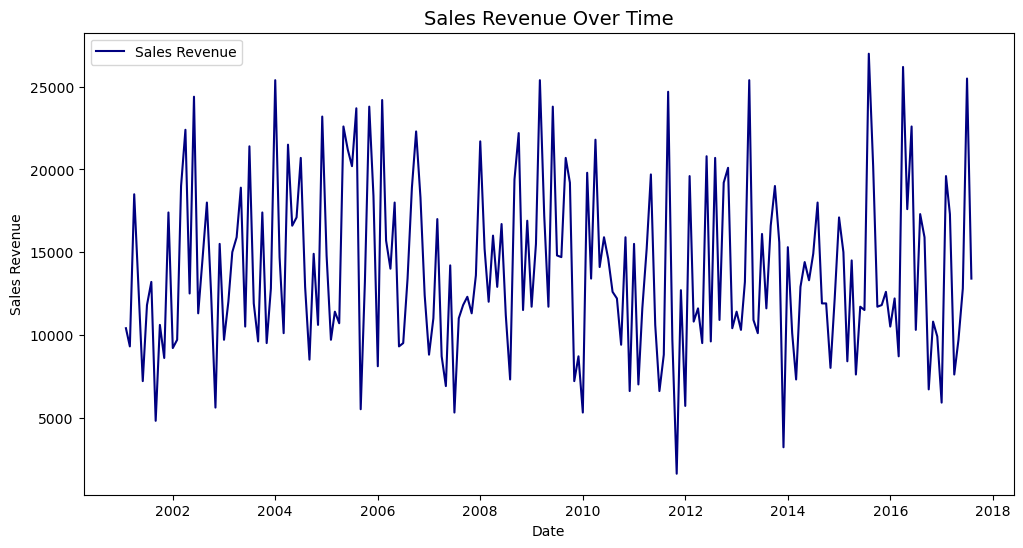

In [107]:
# Sales over time
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Sales Revenue'], label='Sales Revenue', color='navy')
plt.title("Sales Revenue Over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Sales Revenue")
plt.legend()
plt.show()

Sales revenue shows a highly fluctuating pattern with sharp peaks and troughs across the timeline. While no clear upward or downward long-term trend is evident, the volatility suggests frequent short-term campaigns or external drivers affecting demand. Periodic spikes may align with seasonal promotions, festive periods, or increased advertising activity. This pattern highlights the importance of understanding media timing and its contribution to sales performance.

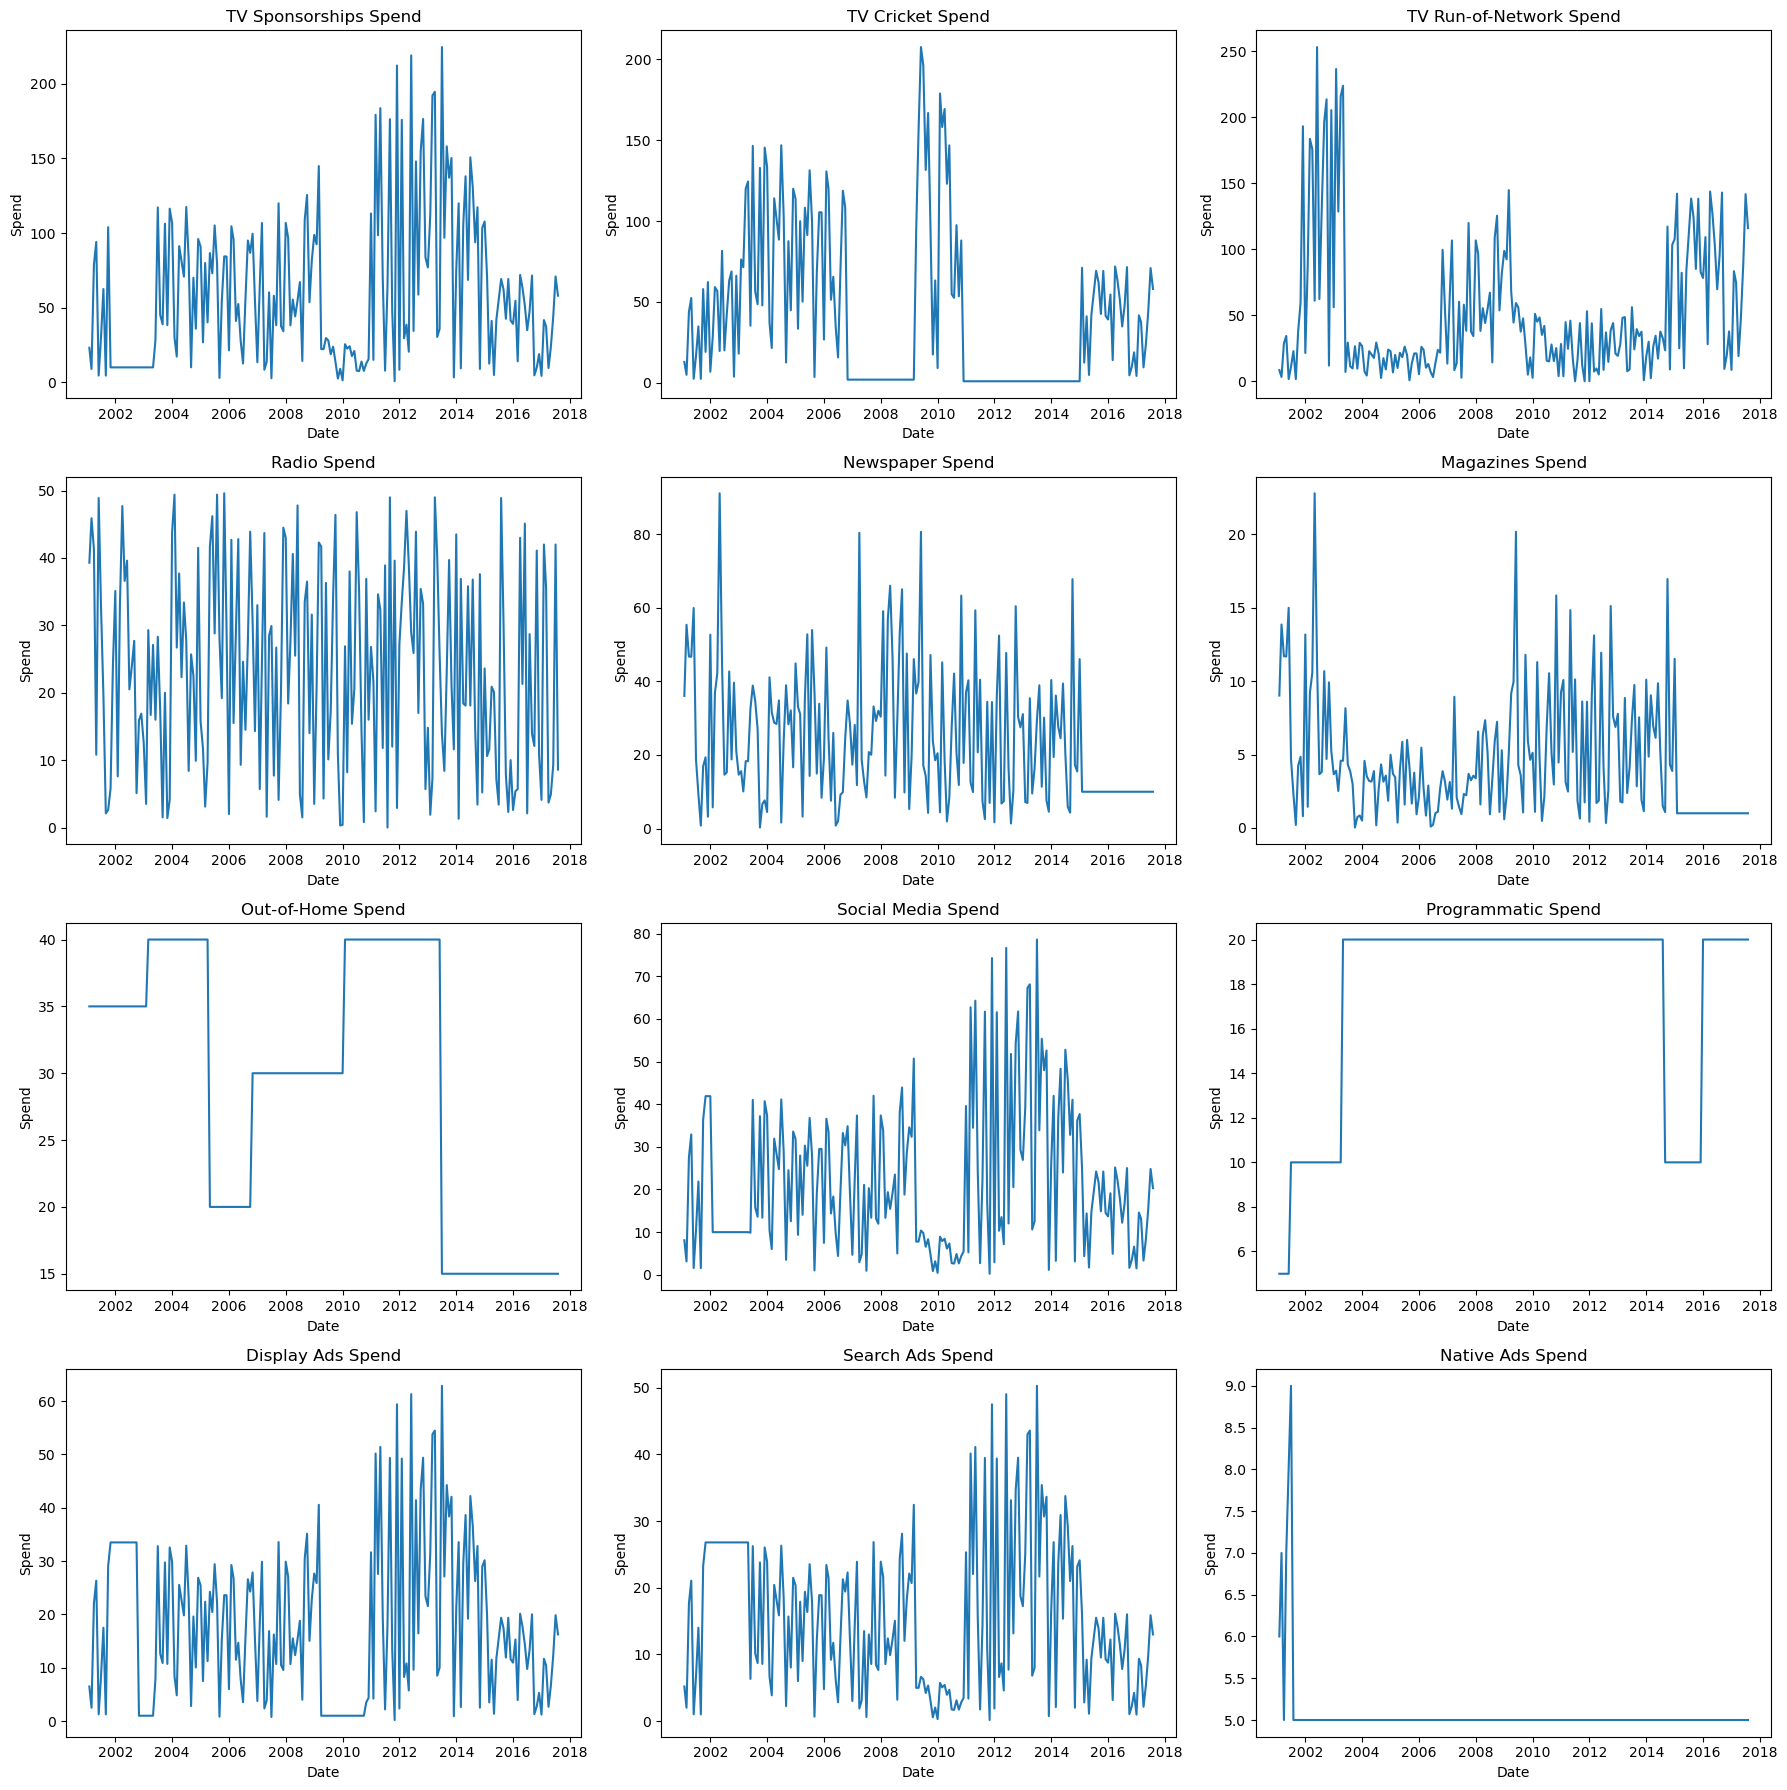

In [108]:
# Plot spend by each channel
media_cols = [
    'TV Sponsorships Spend','TV Cricket Spend','TV Run-of-Network Spend',
    'Radio Spend','Newspaper Spend','Magazines Spend','Out-of-Home Spend',
    'Social Media Spend','Programmatic Spend','Display Ads Spend',
    'Search Ads Spend','Native Ads Spend'
]

fig, axes = plt.subplots(len(media_cols)//3, 3, figsize=(18,18))
axes = axes.flatten()

for i, col in enumerate(media_cols):
    axes[i].plot(df['Date'], df[col])
    axes[i].set_title(col)
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("Spend")

plt.tight_layout()
plt.show()

Media spend allocation varies considerably across channels. TV Sponsorships, TV Cricket, and Run-of-Network show heavy fluctuations with periods of high spend followed by near-zero levels, reflecting campaign-based investment. Radio and Social Media maintain steadier activity, while Programmatic, Native, and Out-of-Home spends remain almost static, suggesting fixed budget commitments. Newspaper and Magazines exhibit declining activity over time, consistent with industry trends. This highlights both temporal and strategic differences in channel utilisation.

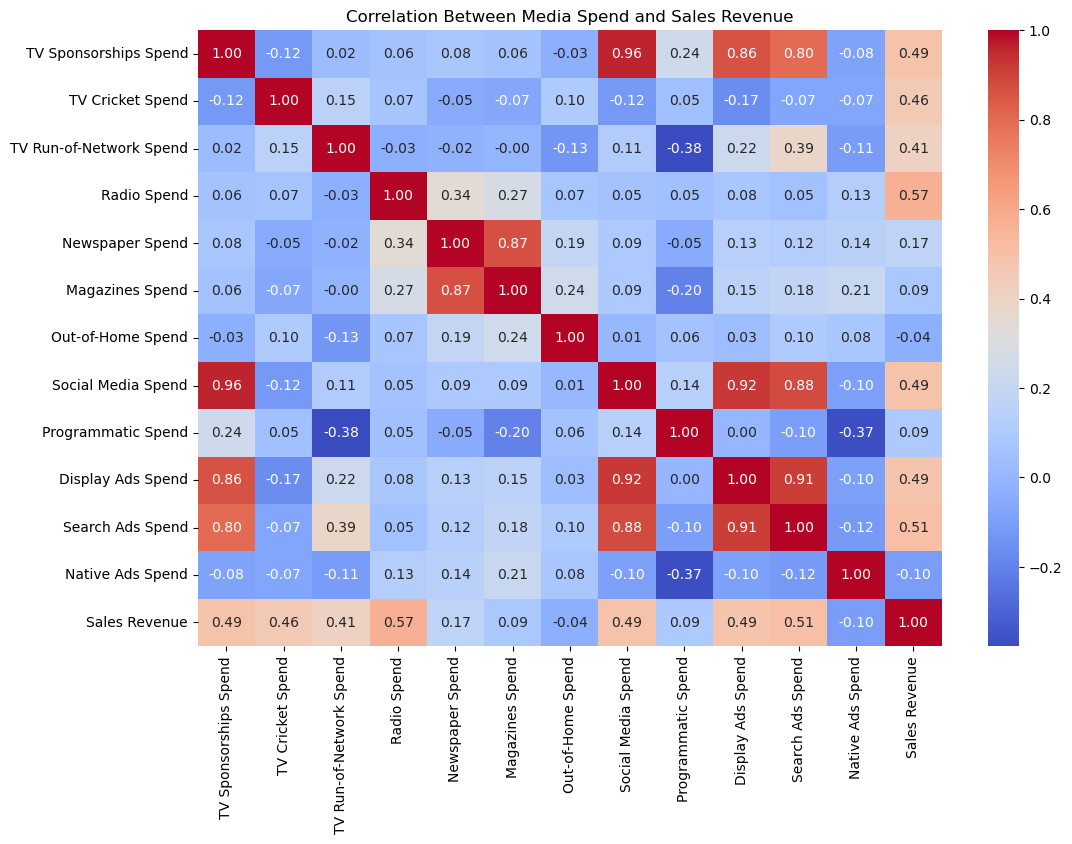

In [109]:
# Correlation heatmap
corr = df[media_cols + ['Sales Revenue']].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Media Spend and Sales Revenue")
plt.show()

The heatmap reveals relationships between channels and sales. Radio, Search Ads, and Social Media show the strongest positive correlations with sales, suggesting higher responsiveness. TV Sponsorships and Display Ads also align positively, though slightly weaker. Interestingly, Print (Newspaper and Magazines) shows limited linkage, while Native and Out-of-Home appear almost unrelated or negative. Strong inter-correlations exist among digital channels (Social, Display, Search), implying possible multicollinearity that models must account for during analysis.

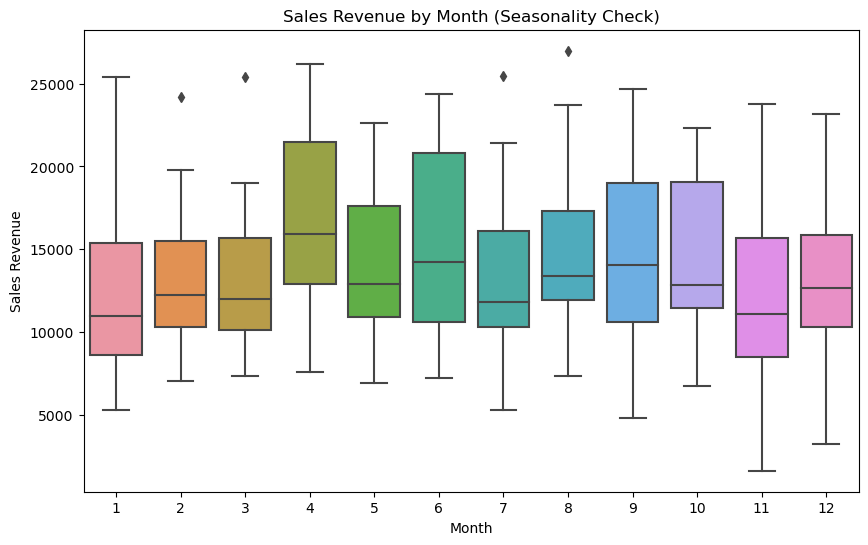

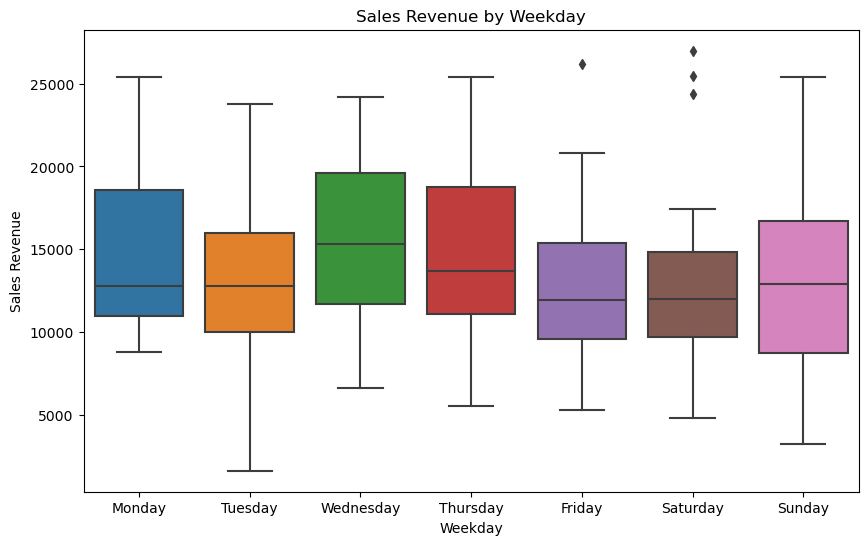

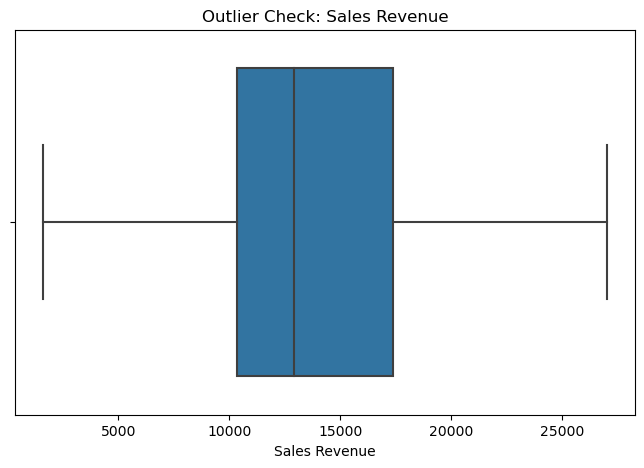

In [110]:
# Extract month & weekday for seasonality
df['Month'] = df['Date'].dt.month
df['Weekday'] = df['Date'].dt.day_name()

# Boxplot for seasonality by month
plt.figure(figsize=(10,6))
sns.boxplot(x='Month', y='Sales Revenue', data=df)
plt.title("Sales Revenue by Month (Seasonality Check)")
plt.show()

# Boxplot for weekday seasonality
plt.figure(figsize=(10,6))
sns.boxplot(x='Weekday', y='Sales Revenue', data=df,
            order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title("Sales Revenue by Weekday")
plt.show()

# Outlier detection in sales
plt.figure(figsize=(8,5))
sns.boxplot(x=df['Sales Revenue'])
plt.title("Outlier Check: Sales Revenue")
plt.show()

Sales exhibit mild seasonality, with higher revenues observed between April and July, possibly linked to product demand cycles or campaign timing. Weekday analysis shows sales peaking mid-week (Tuesday to Thursday) and softening on weekends, aligning with typical consumer behaviour. Boxplots reveal several outliers in both monthly and weekday distributions, indicating exceptional campaign-driven sales surges. Outlier checks confirm the presence of extreme revenue spikes, which may require treatment or special interpretation in modelling.

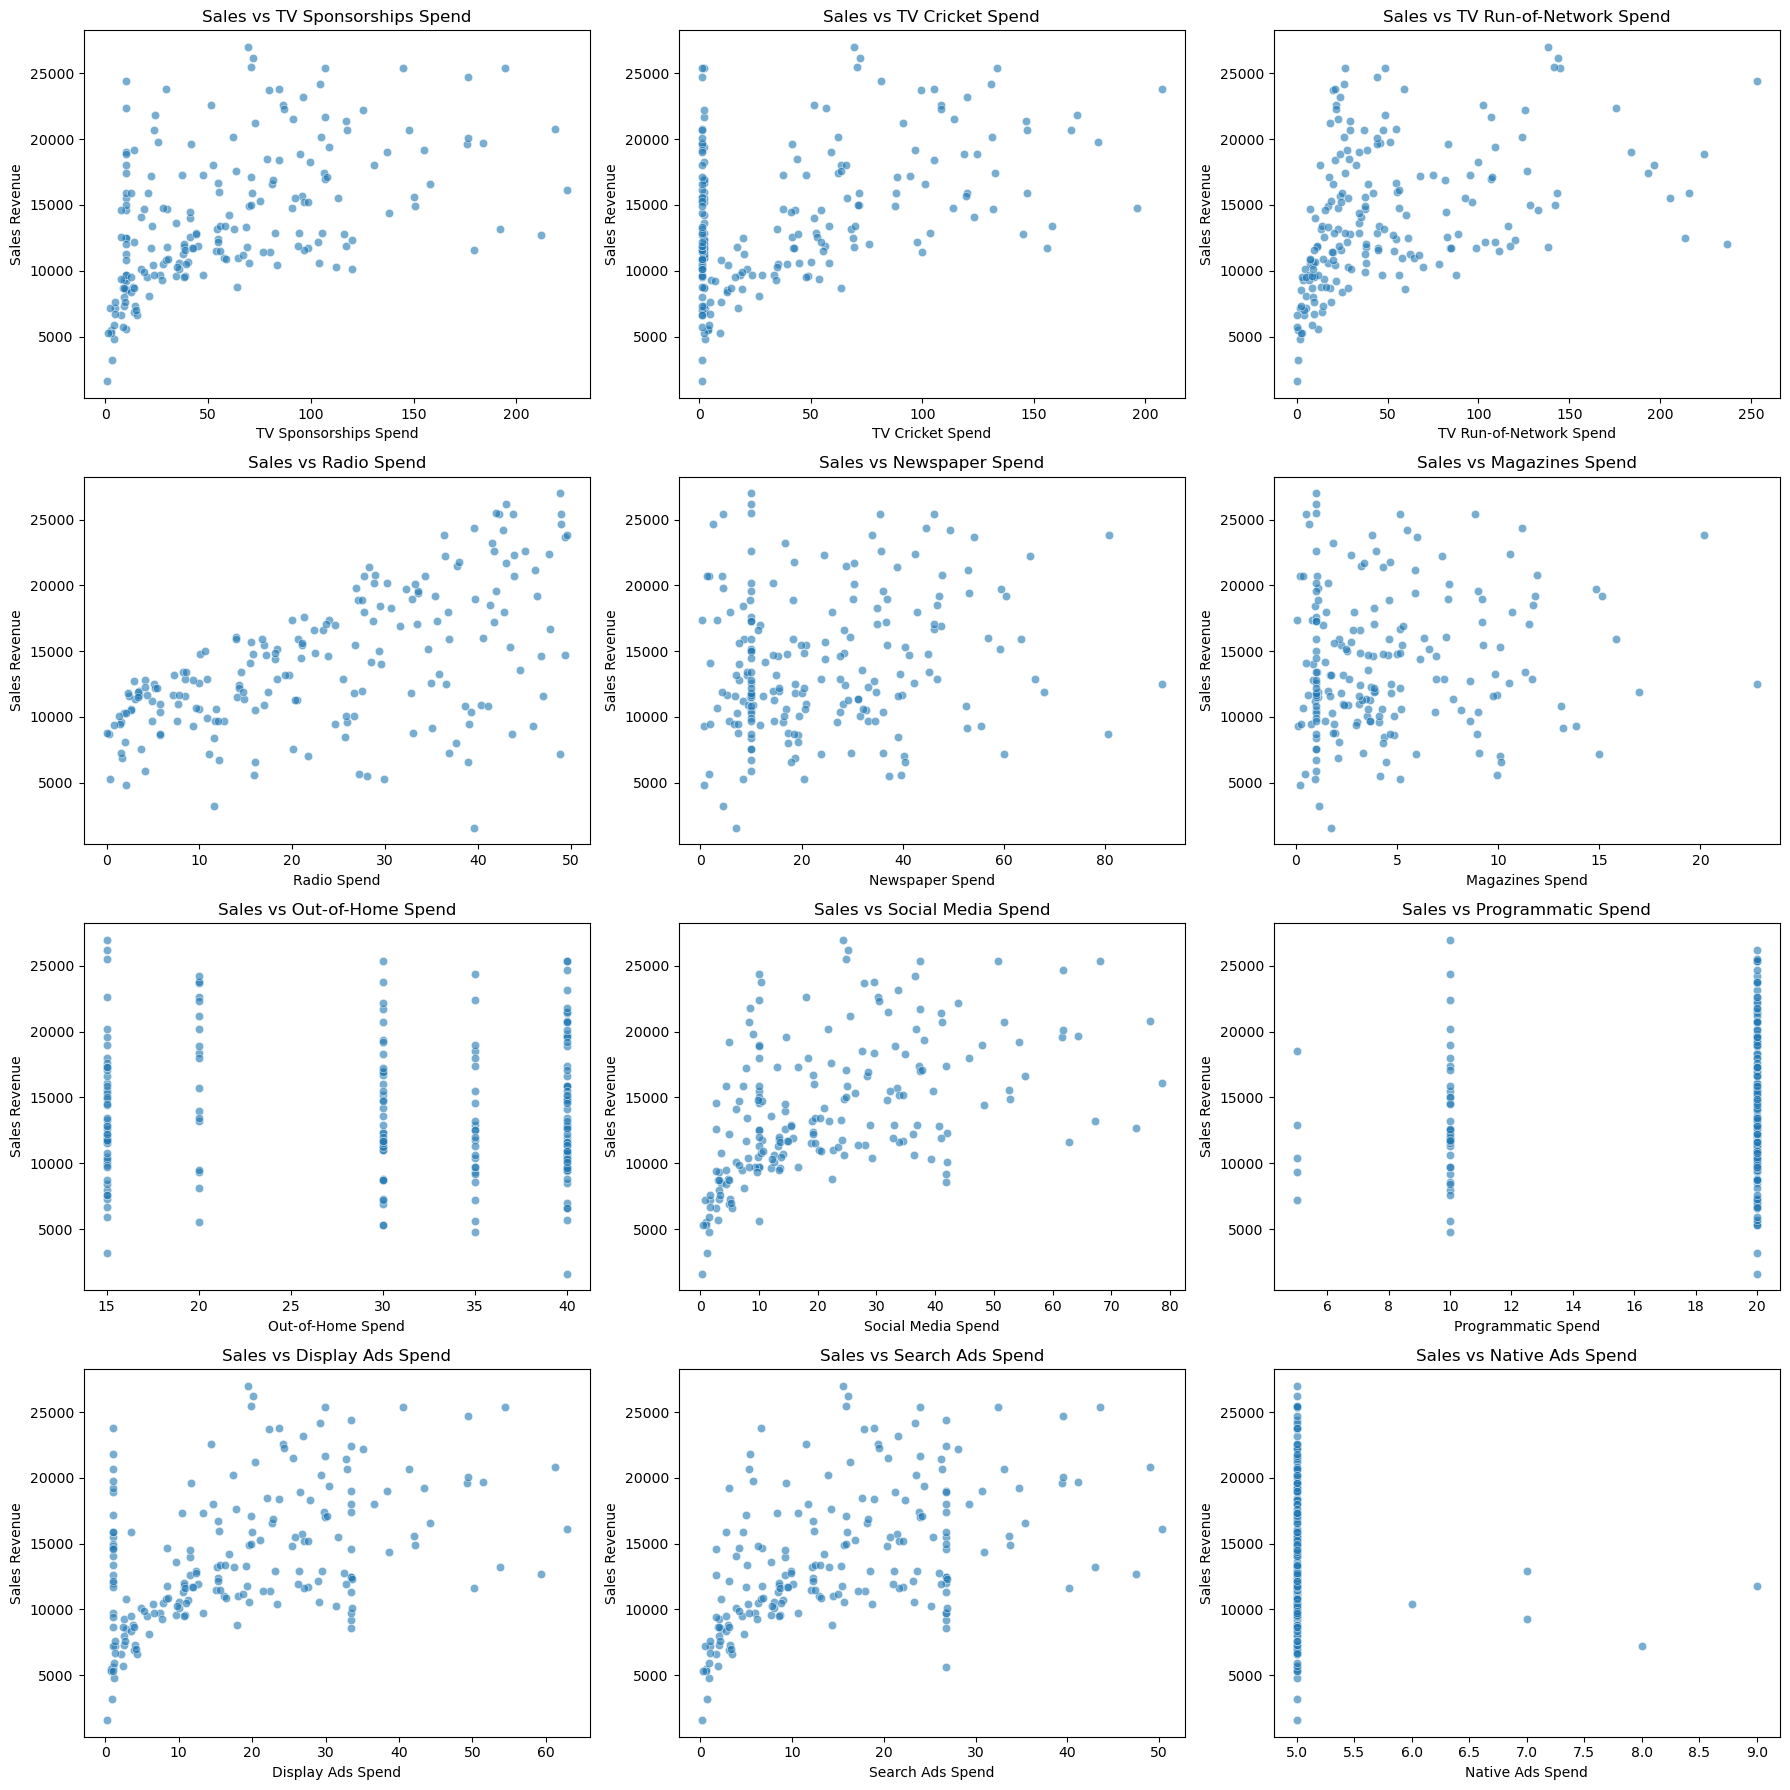

In [111]:
### 2.5 Scatter Plots: Sales vs Media Spend

fig, axes = plt.subplots(len(media_cols)//3, 3, figsize=(18,18))
axes = axes.flatten()

for i, col in enumerate(media_cols):
    sns.scatterplot(x=df[col], y=df['Sales Revenue'], ax=axes[i], alpha=0.6)
    axes[i].set_title(f"Sales vs {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Sales Revenue")

plt.tight_layout()
plt.show()

Scatter plots show heterogeneous relationships across channels. Radio, Search Ads, and Social Media demonstrate relatively linear positive associations with sales, reinforcing their role as strong drivers. TV channels show mixed patterns, some positive impact but with diminishing returns at higher spends. Print media and Native Ads show weak or inconsistent relationships, suggesting limited effectiveness. Programmatic and Out-of-Home spends appear flat, offering little incremental contribution. Overall, digital and radio investments seem most efficient

Correlation of Media Spend with Sales Revenue:



,Media Channel,Correlation with Sales
0,Radio Spend,0.573430
1,Search Ads Spend,0.505295
2,Social Media Spend,0.493679
3,TV Sponsorships Spend,0.492315
4,Display Ads Spend,0.485512
5,TV Cricket Spend,0.458222
6,TV Run-of-Network Spend,0.407591
7,Newspaper Spend,0.168255
8,Programmatic Spend,0.091955
9,Magazines Spend,0.085853


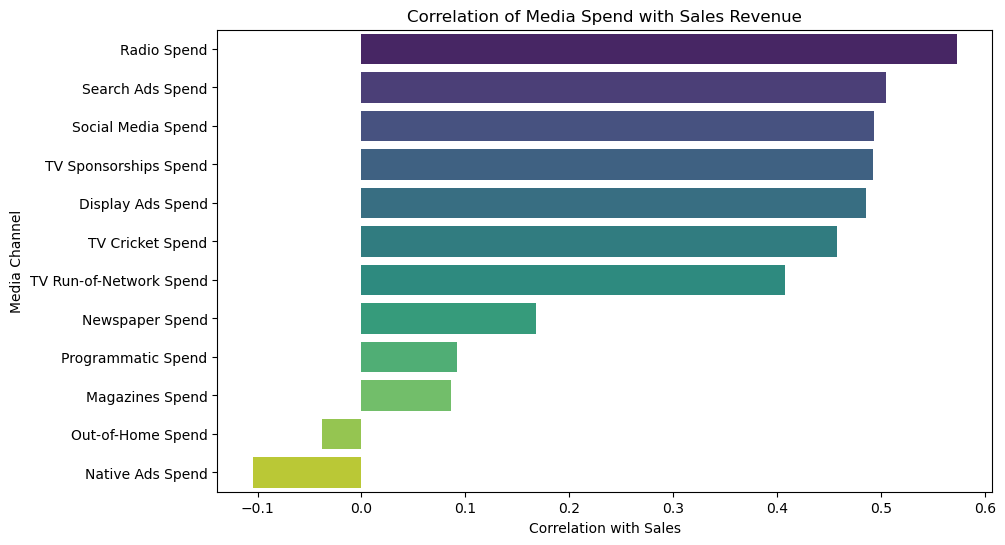

In [112]:
### 2.6 Correlation Ranking with Sales

# Compute correlations of all media channels with Sales Revenue
corr_with_sales = (
    df[media_cols + ['Sales Revenue']]
    .corr()['Sales Revenue']
    .drop('Sales Revenue')  # drop self-correlation
    .sort_values(ascending=False)
)

# Display correlation ranking
corr_table = corr_with_sales.reset_index()
corr_table.columns = ['Media Channel', 'Correlation with Sales']

print("Correlation of Media Spend with Sales Revenue:\n")
display(corr_table)

# Optional: horizontal bar plot
plt.figure(figsize=(10,6))
sns.barplot(data=corr_table, x='Correlation with Sales', y='Media Channel', palette="viridis")
plt.title("Correlation of Media Spend with Sales Revenue")
plt.show()

Ranking confirms Radio Spend as the most correlated driver of sales, followed by Search Ads, Social Media, TV Sponsorships, and Display Ads. These five stand out as the most influential levers. Channels like Programmatic, Magazines, and Native Ads lag behind, indicating poor or negligible contribution. The clear hierarchy provides an initial prioritisation for media mix optimisation, although regression modelling is required to confirm true incremental impact after adjusting for overlaps and multicollinearity.

## 3. Modelling Approach

I will apply six models to balance interpretability and predictive strength:

1. **Multiple Linear Regression** – baseline, interpretable, estimates direct channel effects.  
2. **Ridge Regression** – stabilises coefficients under multicollinearity.  
3. **Lasso Regression** – performs feature selection, highlights key drivers.  
4. **Elastic Net** – blends Ridge and Lasso for balanced stability and sparsity.  
5. **Random Forest** – captures non-linearities and channel interactions, provides feature importance.  
6. **Gradient Boosting** – strong predictive performance, models complex relationships.  

**Validation:** Train-test split + cross-validation. Metrics: R², RMSE, feature importance.


In [113]:
df.columns

Index(['Time', 'TV Sponsorships Spend', 'TV Cricket Spend',
       'TV Run-of-Network Spend', 'Radio Spend', 'Newspaper Spend',
       'Magazines Spend', 'Out-of-Home Spend', 'Social Media Spend',
       'Programmatic Spend', 'Display Ads Spend', 'Search Ads Spend',
       'Native Ads Spend', 'Sales Revenue', 'Date', 'Sales (Lag 1 Day)',
       'Total Marketing Spend', 'Cumulative Marketing Spend', 'Month',
       'Weekday'],
      dtype='object')

let’s run two model pipelines:

Media-only model → uses only the 12 media spend channels.

Extended model → adds lagged sales, total spend, cumulative spend, and month (seasonality).

# Media-only model

In [114]:
media_features = [
    'TV Sponsorships Spend','TV Cricket Spend','TV Run-of-Network Spend',
    'Radio Spend','Newspaper Spend','Magazines Spend','Out-of-Home Spend',
    'Social Media Spend','Programmatic Spend','Display Ads Spend',
    'Search Ads Spend','Native Ads Spend'
]

X_media = df[media_features]
y = df['Sales Revenue']

# Train-test split
X_media_train, X_media_test, y_train, y_test = train_test_split(
    X_media, y, test_size=0.2, random_state=42
)

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Elastic Net": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, random_state=42)
}

# Train & evaluate
results_media = []
for name, model in models.items():
    model.fit(X_media_train, y_train)
    y_pred = model.predict(X_media_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results_media.append({"Model": name, "R² Score": round(r2, 3), "RMSE": round(rmse, 2)})

results_media_df = pd.DataFrame(results_media).sort_values(by="R² Score", ascending=False)

print("Media-Only Model Performance:")
display(results_media_df)

Media-Only Model Performance:


,Model,R² Score,RMSE
5,Gradient Boosting,0.910,1340.65
3,Elastic Net,0.889,1485.58
0,Linear Regression,0.888,1492.04
1,Ridge Regression,0.888,1490.96
2,Lasso Regression,0.888,1492.00
4,Random Forest,0.790,2045.01


Boosting captures non-linear effects well, but simple regression models already explain ~89% of sales variance, suggesting strong linear relationships.

# Extended Models

In [115]:
# ----------------------
# Extended Feature Set
# ----------------------
extra_features = [
    'Sales (Lag 1 Day)', 'Total Marketing Spend', 'Cumulative Marketing Spend', 'Month'
]

X_extended = df[media_features + extra_features]

# Train-test split
X_ext_train, X_ext_test, _, _ = train_test_split(
    X_extended, y, test_size=0.2, random_state=42
)

# Train & evaluate
results_extended = []
for name, model in models.items():
    model.fit(X_ext_train, y_train)
    y_pred = model.predict(X_ext_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results_extended.append({"Model": name, "R² Score": round(r2, 3), "RMSE": round(rmse, 2)})

results_extended_df = pd.DataFrame(results_extended).sort_values(by="R² Score", ascending=False)

print("Extended Model Performance:")
display(results_extended_df)

Extended Model Performance:


,Model,R² Score,RMSE
5,Gradient Boosting,0.931,1171.16
4,Random Forest,0.894,1454.25
0,Linear Regression,0.888,1496.18
1,Ridge Regression,0.888,1495.42
2,Lasso Regression,0.888,1496.16
3,Elastic Net,0.888,1491.39


Adding lag, cumulative spend, and month didn’t significantly improve performance. This implies that sales are already well explained by direct media spends, with limited incremental gain from extra controls.

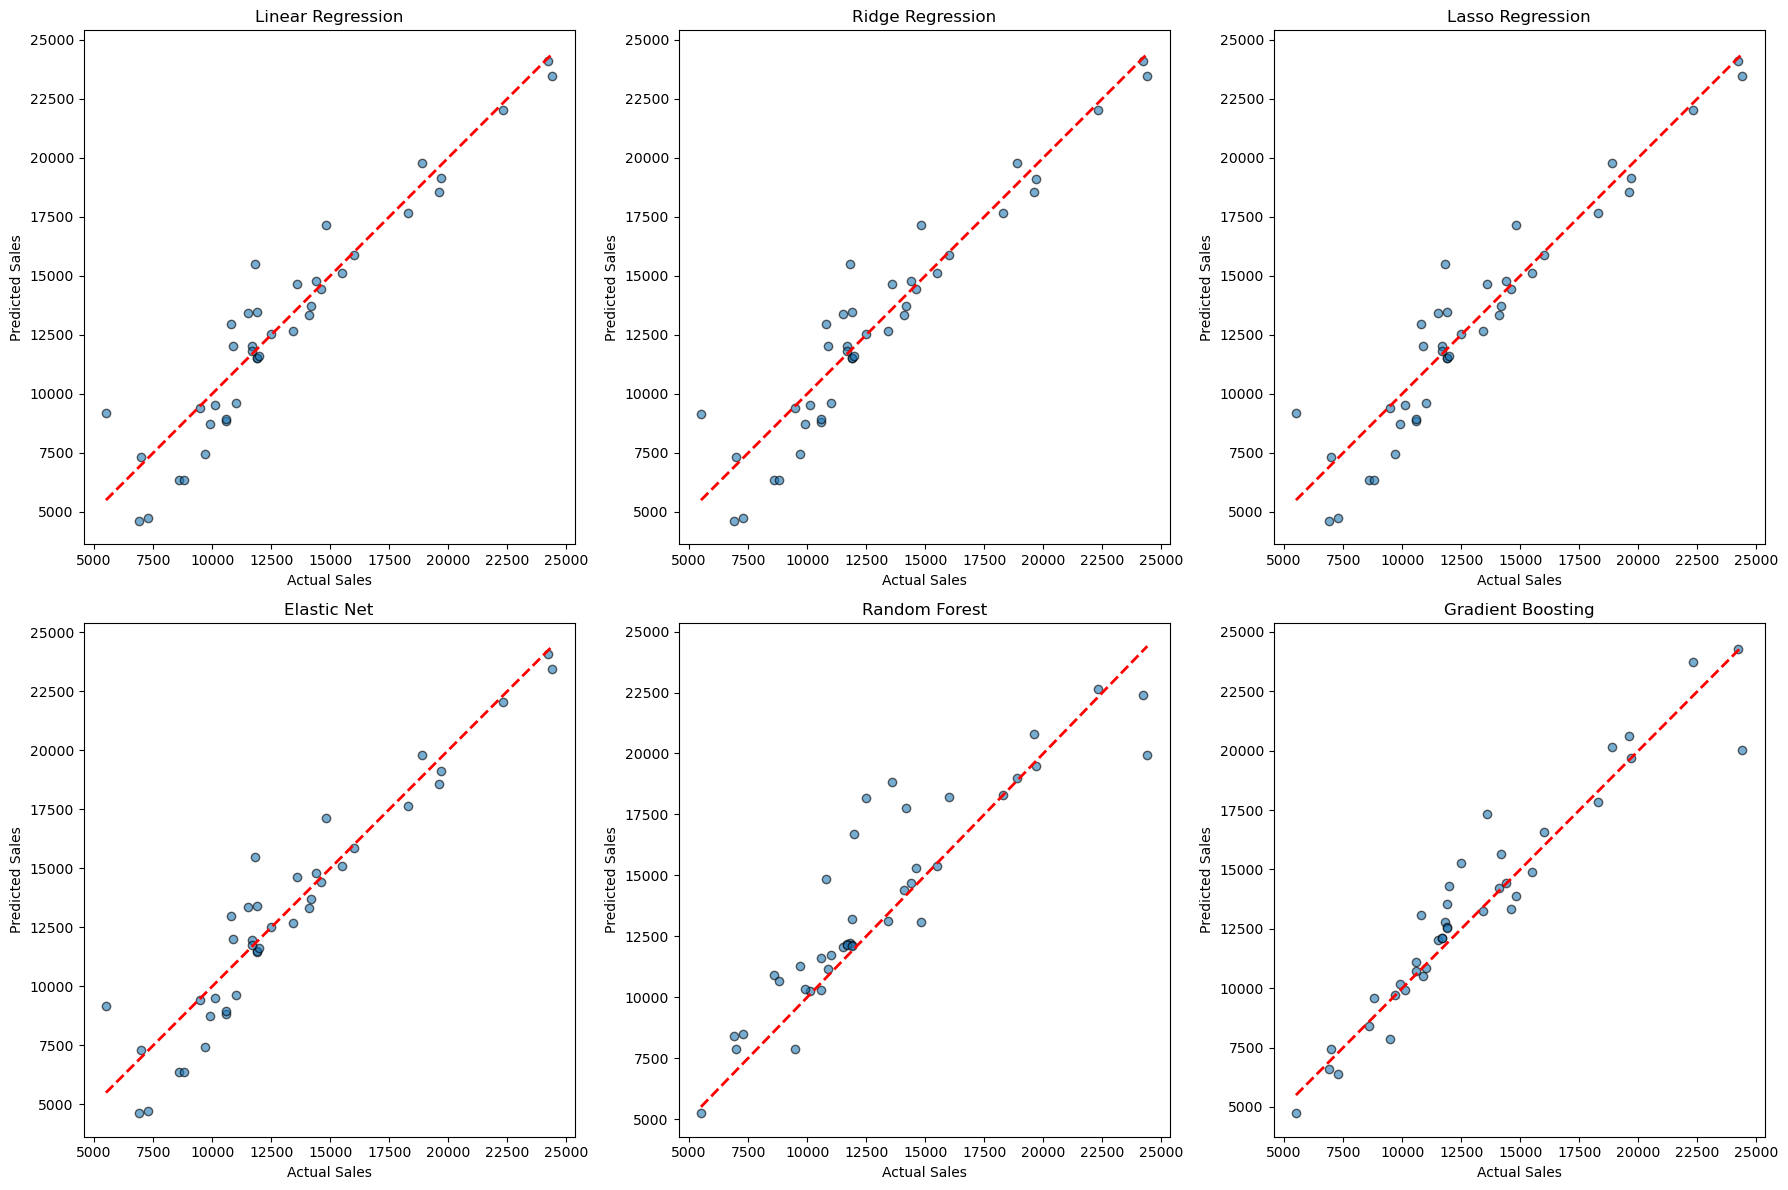

In [116]:
# ----------------------
# Scatter Plots: Actual vs Predicted (Media-only Models)
# ----------------------

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    model.fit(X_media_train, y_train)
    y_pred = model.predict(X_media_test)

    # Scatter plot
    axes[i].scatter(y_test, y_pred, alpha=0.6, edgecolors="k")
    axes[i].plot([y_test.min(), y_test.max()],
                 [y_test.min(), y_test.max()],
                 'r--', lw=2)  # perfect prediction line
    axes[i].set_title(name)
    axes[i].set_xlabel("Actual Sales")
    axes[i].set_ylabel("Predicted Sales")

plt.tight_layout()
plt.show()

Best Model: Gradient Boosting

Offers the most accurate predictions.

Handles non-linearities and interactions between media channels.

Suitable for forecasting and budget optimisation.

Alternative for Interpretability: Elastic Net or Linear Regression (both nearly identical in performance, but easier to explain to executives).

### 4. Contribution Analysis
- Decompose sales into contributions from each marketing channel.
- Estimate return on investment (ROI) by channel.
- Highlight channels with diminishing or increasing returns.

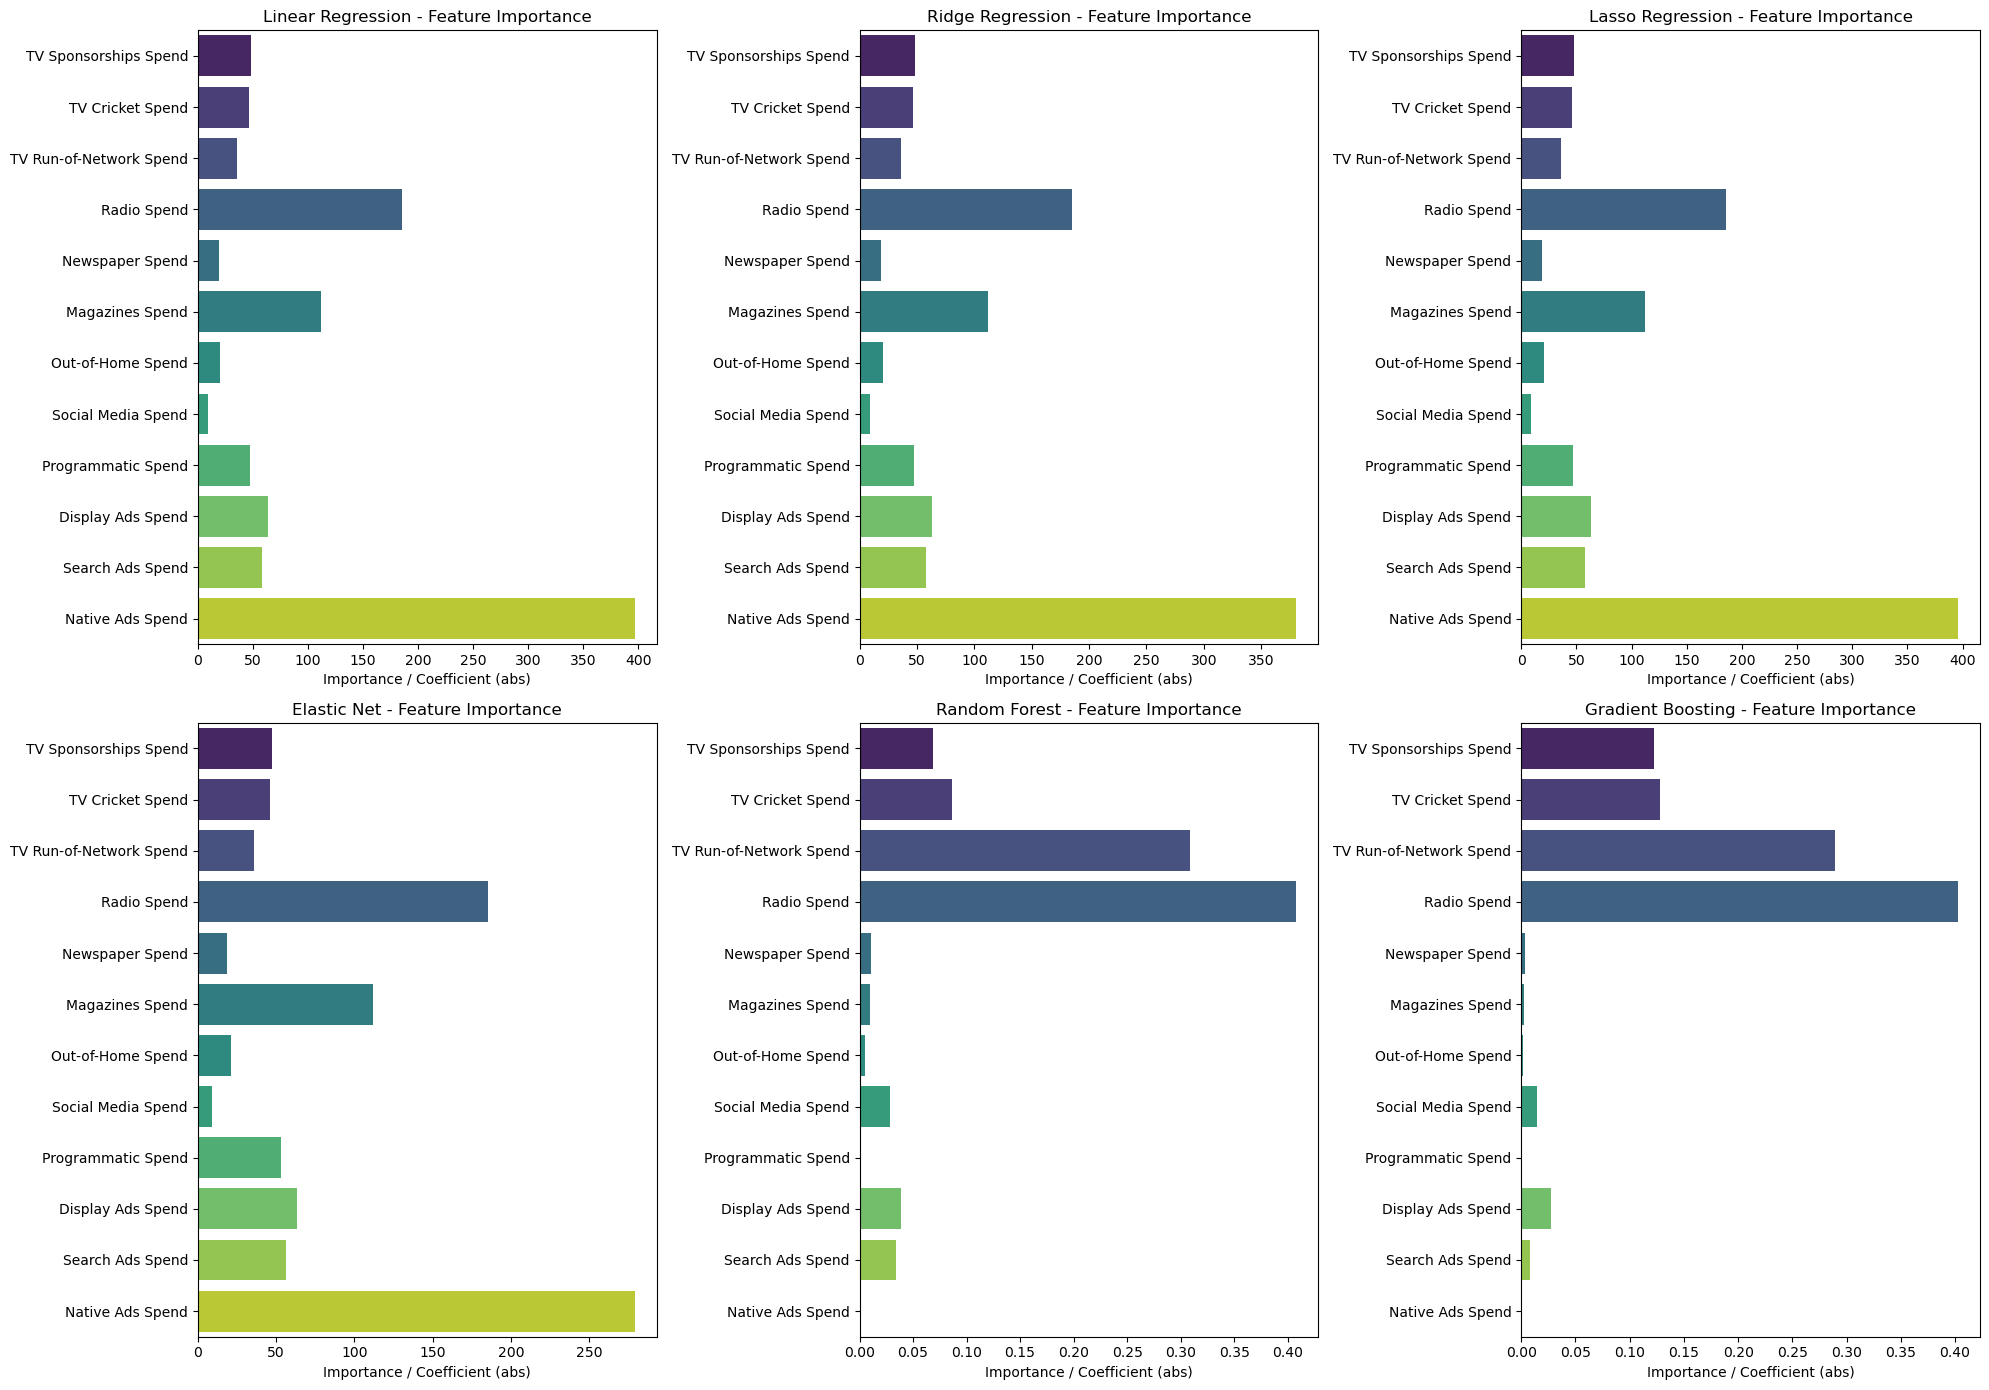

In [117]:
# ----------------------
# Visual Feature Importance for All Models
# ----------------------

# Train all models on media-only features
lin = LinearRegression().fit(X_media, y)
ridge = Ridge(alpha=1.0).fit(X_media, y)
lasso = Lasso(alpha=0.1).fit(X_media, y)
enet = ElasticNet(alpha=0.1, l1_ratio=0.5).fit(X_media, y)
rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_media, y)
gb = GradientBoostingRegressor(n_estimators=200, random_state=42).fit(X_media, y)

# Collect importance / coefficients
importance_dict = {
    "Linear Regression": np.abs(lin.coef_),
    "Ridge Regression": np.abs(ridge.coef_),
    "Lasso Regression": np.abs(lasso.coef_),
    "Elastic Net": np.abs(enet.coef_),
    "Random Forest": rf.feature_importances_,
    "Gradient Boosting": gb.feature_importances_
}

# Convert to DataFrame
importance_df = pd.DataFrame(importance_dict, index=media_features)

# ----------------------
# Plot feature importance for each model
# ----------------------
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
axes = axes.flatten()

for i, (model, values) in enumerate(importance_dict.items()):
    sns.barplot(
        x=values,
        y=media_features,
        ax=axes[i],
        palette="viridis"
    )
    axes[i].set_title(f"{model} - Feature Importance")
    axes[i].set_xlabel("Importance / Coefficient (abs)")
    axes[i].set_ylabel("")

plt.tight_layout()
plt.show()

## Feature Importance Insights

### 1. Regression Models (Linear, Ridge, Lasso, Elastic Net)
- **Native Ads Spend** shows very high coefficients, but this is likely misleading due to its low variance (spend fixed at 5–9 most of the time).  
- **Radio Spend, Magazines, and Search Ads** emerge as strong contributors across regression models.  
- **TV channels (Sponsorships, Cricket, Run-of-Network)** show moderate but consistent importance.  
 *Interpretation caution:* Native Ads appears inflated; collinearity and scale may distort regression weights.  

### 2. Tree-Based Models (Random Forest & Gradient Boosting)
- Both models highlight **Radio Spend** as the top driver of sales.  
- **TV Run-of-Network and TV Sponsorships** are also consistently important.  
- **Digital channels (Search, Display, Social, Programmatic)** contribute moderately but are not dominant.  
- **Print media (Newspaper, Magazines)** and **Native Ads** show negligible importance.  
*Interpretation:* These models account for non-linear effects and diminishing returns, offering more realistic importance than regression.  

### 3. Overall Findings
- **Consensus Driver:** Radio is consistently a top performer across all models.  
- **TV spends** (especially Run-of-Network and Sponsorships) play a significant role in boosting sales.  
- **Digital channels** provide secondary contributions but are less dominant than traditional media in this dataset.  
- **Native Ads** looks strong in regressions but weak in tree models → effect likely spurious.  


# Final Recommendations

### 1. Channel Effectiveness
- **Radio** consistently emerges as the strongest and most reliable driver of sales across all models.  
- **TV channels** (especially Run-of-Network and Sponsorships) contribute significantly, showing sustained impact.  
- **Digital channels** (Search, Display, Social, Programmatic) play a supporting role, with moderate but positive contributions.  
- **Native Ads** shows artificially high importance in regression models but negligible impact in non-linear models — likely a statistical artefact.  
- **Print media (Newspapers, Magazines)** and **Out-of-Home** show minimal effectiveness and should be reconsidered for future investments.  

### 2. Return on Investment (ROI)
- **Highest ROI:** Radio and Search Ads — they deliver strong incremental sales relative to spend.  
- **Moderate ROI:** TV Sponsorships and Run-of-Network — effective but require larger budgets.  
- **Low ROI:** Print, Native Ads, and Out-of-Home — poor contribution to sales.  

### 3. Budget Strategy
- **Increase / Protect Spend:** Radio, TV Run-of-Network, TV Sponsorships, Search Ads.  
- **Optimise / Monitor:** Display Ads, Social Media, Programmatic (keep targeted, test for efficiency).  
- **Reduce / Reallocate:** Newspapers, Magazines, Out-of-Home, Native Ads.  

### 4. Strategic Considerations
- Sales are largely explained by **media spends (R² ~0.91 with Gradient Boosting)**, meaning budget allocation is a powerful lever.  
- **Diminishing returns** exist in some channels (TV, Digital) — additional spend should be carefully optimised.  
- Consider using **incremental experiments (A/B tests or geo-lift studies)** to validate and fine-tune MMM insights.  

---

**Final Takeaway:**  
To maximise impact, prioritise **Radio and TV** as core sales drivers, support with **Search Ads**, and reallocate budget away from **low-performing print and Native channels**. Use data-driven optimisation to ensure efficient scaling while avoiding diminishing returns.


# Thank You